## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/solar.csv")
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
0,0,25.896492,-97.460358,Texas,large_community,5.634079,39,5.00,0.235,90633.862770,21.276596,6132.00,4782960.0
1,1,26.032654,-97.738098,Texas,small_utility,5.616413,39,5.00,0.234,91307.484990,21.367521,6132.00,4782960.0
2,2,26.059063,-97.208252,Texas,small_community,5.746738,39,0.15,0.239,2621.097459,0.627615,183.96,143488.8
3,3,26.078449,-98.073364,Texas,small_utility,5.742196,39,5.00,0.239,87439.036330,20.920502,6132.00,4782960.0
4,4,26.143227,-98.311340,Texas,small_utility,5.817187,39,5.00,0.242,85241.850210,20.661157,6132.00,4782960.0


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
10549,10549,43.146587,-93.410431,Iowa,small_residential,4.739488,45,0.005,0.197,128.523807,0.025381,6.132,5518.80
4229,4229,32.752232,-116.028137,California,small_utility,6.851059,41,5.000,0.285,61458.036490,17.543860,6132.000,5028240.00
4414,4414,35.003220,-101.967285,Texas,large_community,6.262835,39,5.000,0.261,73412.458260,19.157088,6132.000,4782960.00
10478,10478,42.722588,-101.106384,Nebraska,large_community,5.437910,43,5.000,0.227,97212.780910,22.026432,6132.000,5273520.00
8767,8767,35.880466,-99.368011,Oklahoma,medium_residential,5.918760,41,0.010,0.247,164.166121,0.040486,12.264,10056.48


Looking at each dataset, we can identify which variables we want to use for our models.

In [5]:
X = df.loc[:, ['lat','long','capacity']]
y_energy = df['generated_energy'].values
y_cost = df['cost'].values

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [6]:
X_train = X[:9500]
X_test = X[9500:]
y_energy_train = y_energy[:9500]
y_energy_test = y_energy[9500:]
y_cost_train = y_cost[:9500]
y_cost_test = y_cost[9500:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [7]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 2.03229033,  0.92873139, -0.43905719],
       [-0.5962383 , -1.96682005, -0.43098755],
       [-0.02700756, -0.16672944, -0.43098755],
       ...,
       [-0.12947216, -0.24196866, -0.43905719],
       [ 2.41359832,  0.38433555, -0.43904104],
       [-0.0831422 ,  0.65286873, -0.43098755]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [8]:
energy_reg = svm.SVR()
cost_reg = svm.SVR()
energy_reg.fit(X_train, y_energy_train)
cost_reg.fit(X_train, y_cost_train)

SVR()

With a trained model, predictions can now be made.

In [10]:
#| label: prediction-comparisons

energy_display = y_energy_test
cost_display = y_cost_test
energy_preds = energy_reg.predict(X_test)
cost_preds = cost_reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {energy_preds[i]:.2f}\tactual energy: {energy_display[i]:.2f}\tpredicted cost: {cost_preds[i]:.2f}\tactual cost: {cost_display[i]:.2f}")

Predictions
----------------------
predicted energy: 2494.27	actual energy: 6.13	predicted cost: 1913464.63	actual cost: 4905.60
predicted energy: 2438.26	actual energy: 2452.80	predicted cost: 1913207.65	actual cost: 1913184.00
predicted energy: 2753.60	actual energy: 183.96	predicted cost: 1913890.42	actual cost: 172922.40


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [11]:
#| label: metrics

energy_r2 = metrics.r2_score(y_energy_test, energy_preds, multioutput="raw_values")
energy_rmse = metrics.root_mean_squared_error(y_energy_test, energy_preds, multioutput="raw_values")
energy_mape = metrics.mean_absolute_percentage_error(y_energy_test, energy_preds, multioutput="raw_values")

cost_r2 = metrics.r2_score(y_cost_test, cost_preds, multioutput="raw_values")
cost_rmse = metrics.root_mean_squared_error(y_cost_test, cost_preds, multioutput="raw_values")
cost_mape = metrics.mean_absolute_percentage_error(y_cost_test, cost_preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"energy_r2\t{energy_r2}\ncost_r2\t{cost_r2}\nenergy_rmse\t{energy_rmse}\ncost_rmse\t{cost_rmse}\nenergy_mape\t{energy_mape}\ncost_mape\t{cost_mape}")

Metric	Score
-----------------------
energy_r2	[-0.21012622]
cost_r2	[-0.20850399]
energy_rmse	[880927.68663408]
cost_rmse	[6.87646055e+08]
energy_mape	[81.95543371]
cost_mape	[81.30935189]


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [12]:
#| label: k-fold-cross-validation-table-energy

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(energy_reg, X, y_energy, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: -0.19080402178052483
RMSE Average: 835719.6572480934
MAPE Average: 83.11834411696152


,fit_time,score_time,test_r2,test_rmse,test_mape
0,5.711730,1.212786,-0.209988,858270.866365,77.702522
1,3.275041,1.064659,-0.175722,825723.536395,84.581029
2,3.531009,1.017413,-0.196909,829640.908412,78.586396
3,3.094635,0.965153,-0.190046,798942.604556,84.428920
4,3.407629,1.058627,-0.200488,874252.589933,87.739410
5,3.160279,0.958006,-0.192127,847512.024413,81.573179
6,3.356327,0.942312,-0.196893,867838.629564,80.135358
7,3.356798,0.907112,-0.171115,804687.181740,87.416628
8,3.331655,0.908973,-0.201225,850576.101493,82.517218
9,3.200842,0.976853,-0.173528,799752.129609,86.502780


In [13]:
#| label: k-fold-cross-validation-table-cost

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(cost_reg, X, y_cost, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: -0.19100059475135955
RMSE Average: 657874231.9115219
MAPE Average: 83.9877821694812


,fit_time,score_time,test_r2,test_rmse,test_mape
0,3.926678,0.935226,-0.208953,6.800997e+08,78.355280
1,3.605959,0.954635,-0.176153,6.491585e+08,86.265737
2,3.739908,1.006299,-0.195172,6.610066e+08,78.606084
3,3.506410,0.996119,-0.190897,6.284168e+08,84.443426
4,3.706270,0.962898,-0.200360,6.923436e+08,88.103419
5,3.648341,0.965594,-0.192996,6.650218e+08,82.503671
6,3.819171,0.977612,-0.196144,6.854944e+08,81.365376
7,3.566598,0.932271,-0.172927,6.276688e+08,88.890206
8,3.490718,0.985235,-0.200951,6.666649e+08,83.557596
9,3.594051,0.949818,-0.175453,6.228673e+08,87.787026


### Graphs

Graphs of the SVR model fits on each on the input features, for each target.

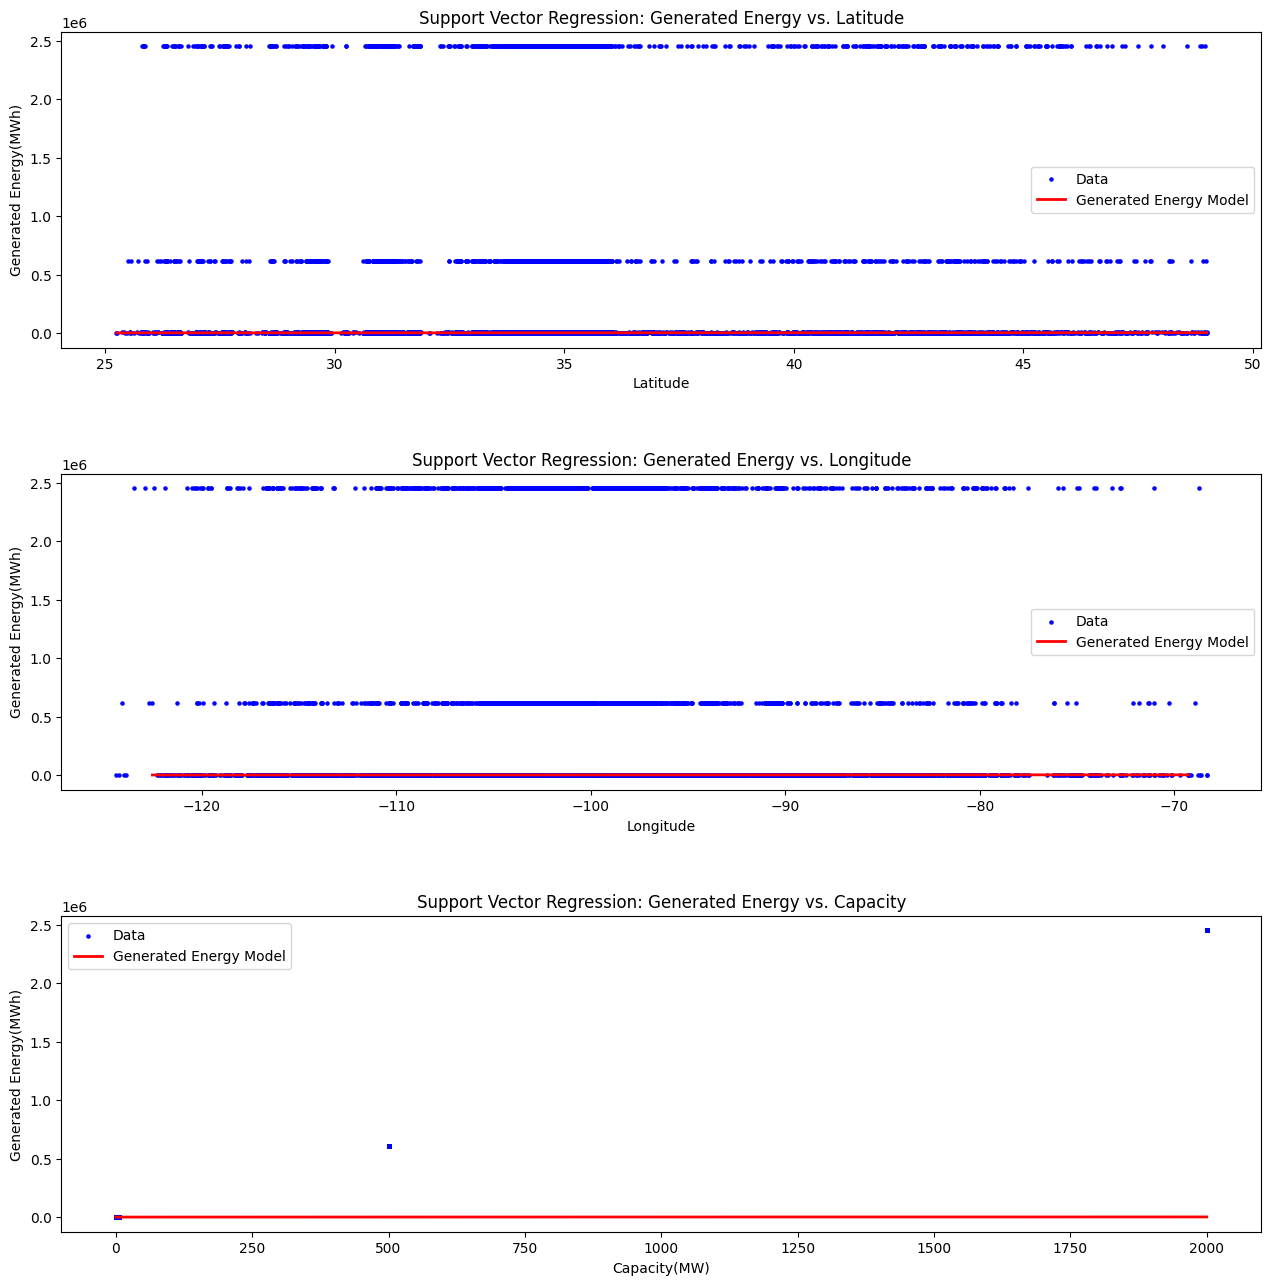

In [18]:
#| label: fig-generated-energy-vs-input-features

plot_lat_x = X[9500:].loc[:,['lat']].sort_values(by=['lat'])
plot_long_x = X[9500:].loc[:,['long']].sort_values(by=['long'])
plot_cap_x = X[9500:].loc[:,['capacity']].sort_values(by=['capacity'])
plot_energy_y = pd.DataFrame(energy_preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y_energy, color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Generated Energy(MWh)")
axis[0].set_title("Support Vector Regression: Generated Energy vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y_energy, color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Generated Energy(MWh)")
axis[1].set_title("Support Vector Regression: Generated Energy vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y_energy, color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Generated Energy(MWh)")
axis[2].set_title("Support Vector Regression: Generated Energy vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

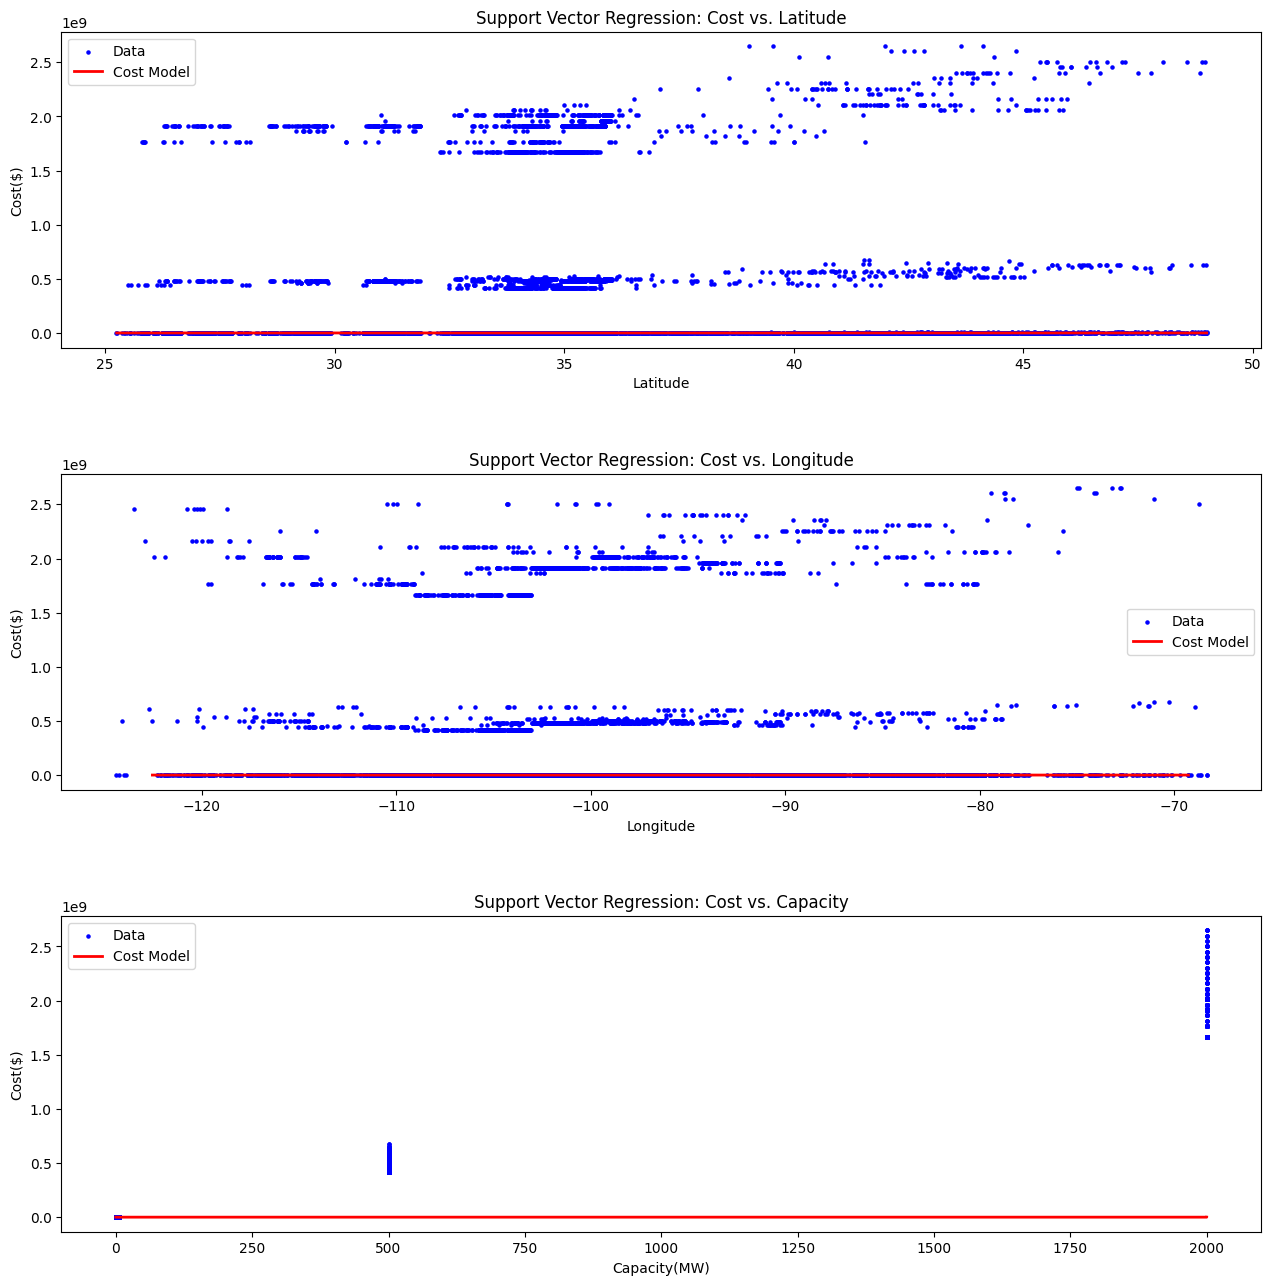

In [19]:
#| label: fig-cost-vs-input-features

plot_cost_y = pd.DataFrame(cost_preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y_cost, color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Cost($)")
axis[0].set_title("Support Vector Regression: Cost vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y_cost, color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Cost($)")
axis[1].set_title("Support Vector Regression: Cost vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y_cost, color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Cost($)")
axis[2].set_title("Support Vector Regression: Cost vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()